## FCNN with a boolean output indicating the likelihood of the image containing nerve

Submission 15, scored 0.67959

In [2]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [3]:
_d = np.load('../data/data_clean_128_train.npz')
X = _d['X']
Y = _d['Y']
X_pids = _d['pids']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [4]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_full = _d['X'][:,None,:,:]
Y_full = _d['Y'][:,None,:,:]

In [5]:
print X.shape
print Y.shape

(3906, 128, 128)
(3906, 128, 128)


In [6]:
# Split patients in train/test
train_pids, test_pids = train_test_split(np.unique(X_pids), test_size=0.1)
print train_pids
print test_pids

[16 42  5 40 41 35 29 31 12 34 25 43  9  3 19 24 38 28 10 32  2 45 37 14 46
 20  7 47 18 26 21 33 27 13 44 11  8  4 17 15 30 36]
[23 39 22  6  1]


In [7]:
train_indices = np.flatnonzero(np.in1d(X_pids, train_pids))
test_indices = np.flatnonzero(np.in1d(X_pids, test_pids))
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices][:,None]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices][:,None]
Y_test = Y[test_indices][:,None,:,:]

In [8]:
print X_train.shape
print Y_train.shape
print X_test.shape
print X_train.min(), X_train.max()

(3480, 1, 128, 128)
(3480, 1, 128, 128)
(426, 1, 128, 128)
0.0 1.0


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


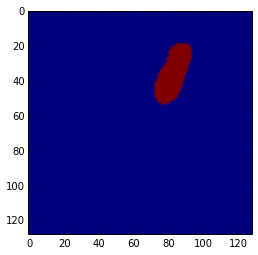

In [9]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [10]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [11]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=0.75'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [12]:
import theano
print theano.config.device

gpu0


In [13]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
input_img = Input(shape=(3, 16, 16))
x = Convolution2D(16, 3, 3, border_mode='same')(input_img)
x = Maxout2D(5, 7)(x)

model = Model(input=input_img, output=x)
model.compile(optimizer='adam', loss='mse')
print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 3, 16, 16)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 16, 16)  448         input_1[0][0]                    
____________________________________________________________________________________________________
maxout2d_1 (Maxout2D)              (None, 5, 16, 16)   595         convolution2d_1[0][0]            
Total params: 1043
____________________________________________________________________________________________________


In [14]:
input_img = Input(shape=input_shape, name='input_img')
x = Convolution2D(16, 3, 3, border_mode='same')(input_img)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Dropout(0.25)(x)
x = Maxout2D(16, 2)(x)
pool1 = x = MaxPooling2D((2, 2), name='pool1')(x)

x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Dropout(0.25)(x)
x = Maxout2D(16, 2)(x)
pool2 = x = MaxPooling2D((2, 2), name='pool2')(x)

x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Convolution2D(32, 3, 3, border_mode='same')(x)
x = Dropout(0.25)(x)
x = Maxout2D(16, 2)(x)
pool3 = x = MaxPooling2D((2, 2), name='pool3')(x)

# -- binary presence part
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Dropout(0.25)(x)
x = Maxout2D(16, 2)(x)
pool4 = x = MaxPooling2D((2, 2), name='pool4')(x)

x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = Dropout(0.25)(x)
x = Maxout2D(16, 2)(x)
pool5 = x = MaxPooling2D((2, 2), name='pool5')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(x)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# -- location map
x = Convolution2D(8, 3, 3, border_mode='same')(pool3)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Maxout2D(4, 2)(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='concat', concat_axis=1)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Maxout2D(4, 2)(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='concat', concat_axis=1)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Convolution2D(8, 3, 3, border_mode='same')(x)
x = Maxout2D(4, 2)(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
loss='binary_crossentropy'
metrics={'outbin': 'accuracy'}
model.compile(optimizer='adam',
              loss=loss,
              loss_weights=[1., 0.01],
              metrics=metrics)

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_img (InputLayer)             (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 16, 128, 128)160         input_img[0][0]                  
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)    (None, 16, 128, 128)2320        convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 16, 128, 128)0           convolution2d_3[0][0]            
___________________________________________________________________________________________

In [15]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils.visualize_util import plot
#plot(model, to_file='model.png')

In [19]:
if False:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {'outmap': Y_train, 'outbin': Y_train_binary},
        batch_size=64,
        validation_data=(X_test, {'outmap': Y_test, 'outbin': Y_test_binary}),
        nb_epoch=60,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(
        open(os.path.join(model_dir, 'architecture.json')).read(),
        custom_objects={'Maxout2D' : Maxout2D}
    )
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  loss_weights=[1., 0.01])
    
    print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_img (InputLayer)             (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D)   (None, 16, 128, 128)160         input_img[0][0]                  
____________________________________________________________________________________________________
convolution2d_35 (Convolution2D)   (None, 16, 128, 128)2320        convolution2d_34[0][0]           
____________________________________________________________________________________________________
dropout_11 (Dropout)               (None, 16, 128, 128)0           convolution2d_35[0][0]           
___________________________________________________________________________________________

In [17]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.hdf5'))

(1, 16, 128, 128)
(1, 16, 128, 128)


<matplotlib.colorbar.Colorbar instance at 0x7f29d2a59c68>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


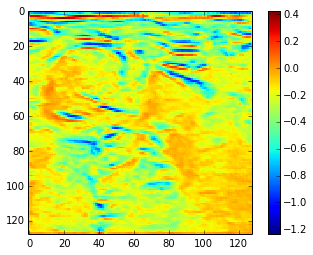

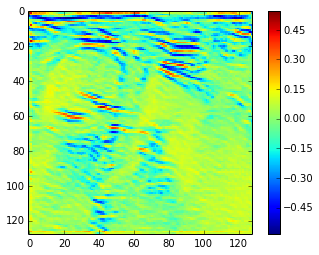

In [20]:
input_img = model.input
conv1 = model.layers[1].output
_f = K.function([K.learning_phase(), input_img], [conv1])
_convout = _f([0, X_test[30:31]])[0]
print _convout.shape

maxout1 = model.layers[3].output
_f = K.function([K.learning_phase(), input_img], [maxout1])
_maxout = _f([0, X_test[30:31]])[0]
print _maxout.shape

pl.figure()
pl.imshow(_convout[0, 0], interpolation='nearest')
pl.colorbar()
pl.figure()
pl.imshow(_maxout[0, 0], interpolation='nearest')
pl.colorbar()

In [21]:
def predict(X):
    Y_pred, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 150:# or Y_pred_binary[i] < 0.2:
            Y_pred[i,:] = 0
        pass
    return Y_pred, Y_pred_proba, Y_pred_binary

Y_pred, Y_pred_proba, Y_pred_binary = predict(X_test)
Y_full_pred, Y_full_pred_proba, Y_full_pred_binary = predict(X_full)

print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)
print "avg test set score : ", utils.average_dice_coefficient(Y_pred, Y_test)
print "full set score : ", utils.dice_coefficient(Y_full_pred, Y_full)
print "avg full set score : ", utils.average_dice_coefficient(Y_full_pred, Y_full)

test set score :  0.698693179852
avg test set score :  0.880928348371
full set score :  0.589916741328
avg full set score :  0.716617432796


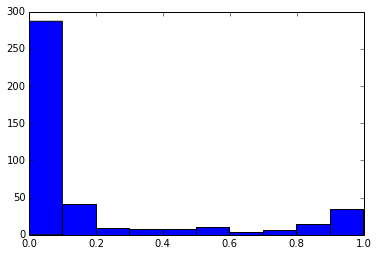

In [22]:
_ = pl.hist(Y_pred_binary)

In [23]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

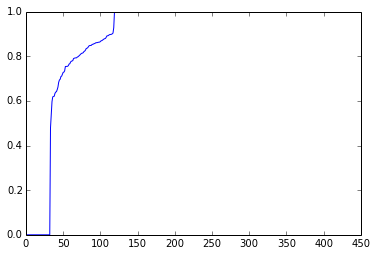

In [24]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

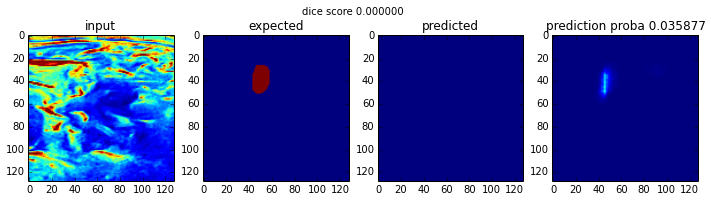

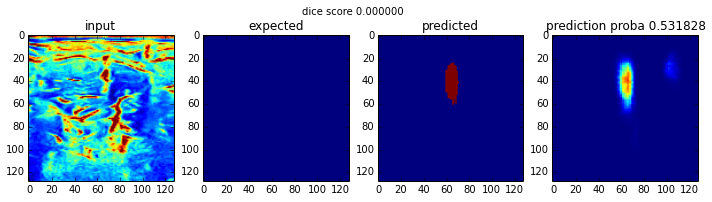

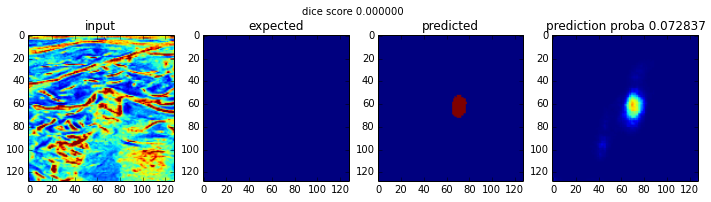

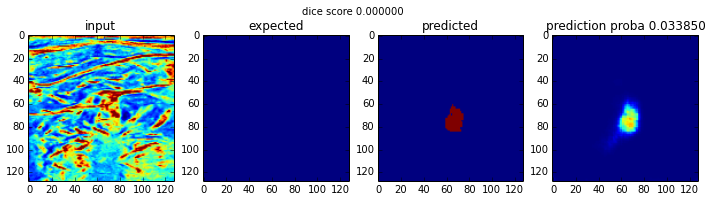

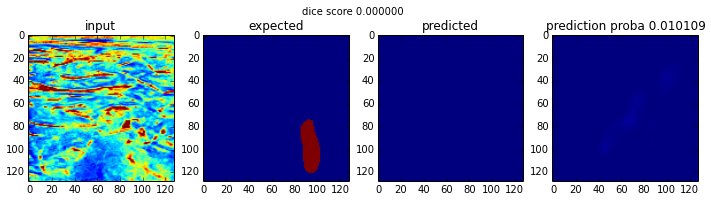

In [27]:
#i = 50
#i = 47

for i in lowest[25:30]:
#for i in lowest[:5]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    #print np.sum(Y_pred[i].squeeze())
    pl.title('prediction proba %f' % Y_pred_binary[i])
    pl.imshow(Y_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Filters visualization

In [31]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [32]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [33]:
import keras.backend as K

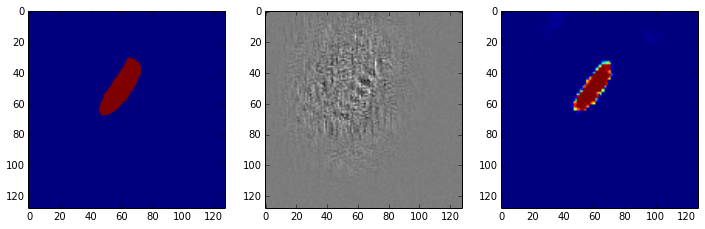

In [34]:
# Dream for the classifmap output
def dream_output(output):
    layer_output = layer_dict['outmap'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output[None,:,:,:] - layer_output))

    # compute the gradient of the input picture wrt this loss
    input_img = layer_dict['input_img'].input
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()
    
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    pred_map, binary_pred = model.predict(img[None,None,:,:])
    return img, pred_map

i = 15
img, pred_map = dream_output(Y_full[i])
pl.figure(figsize=(12, 4))
pl.subplot(131)
pl.imshow(Y_full[i].squeeze())
pl.subplot(132)
pl.imshow(img, cmap=cm.gray)
pl.subplot(133)
pl.imshow(pred_map.squeeze())

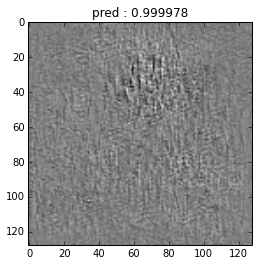

In [41]:
# Dream for the binary output
def dream_binoutput(output):
    
    layer_output = layer_dict['outbin'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output - layer_output[:, 0]))
    
    input_img = layer_dict['input_img'].input

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    
    step = 0.1
    for i in range(40):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    _, model_pred = model.predict(img[None,None,:,:])
    return img, model_pred

img, model_pred = dream_binoutput(1)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

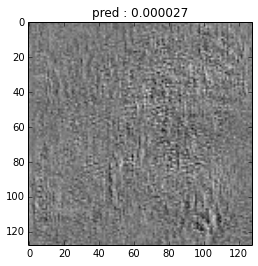

In [42]:
img, model_pred = dream_binoutput(0)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

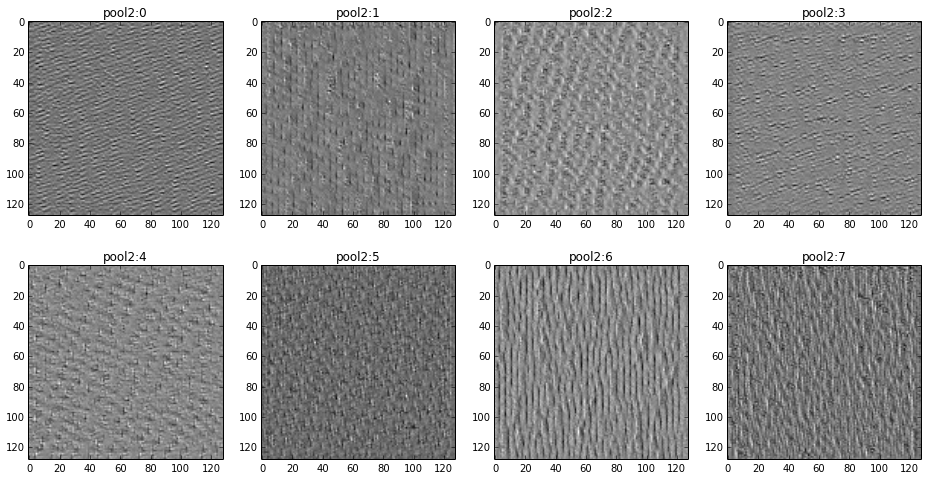

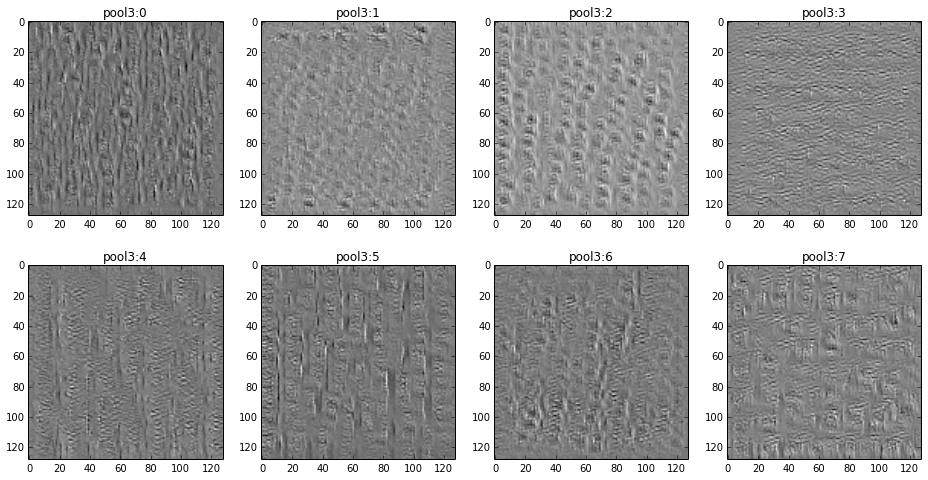

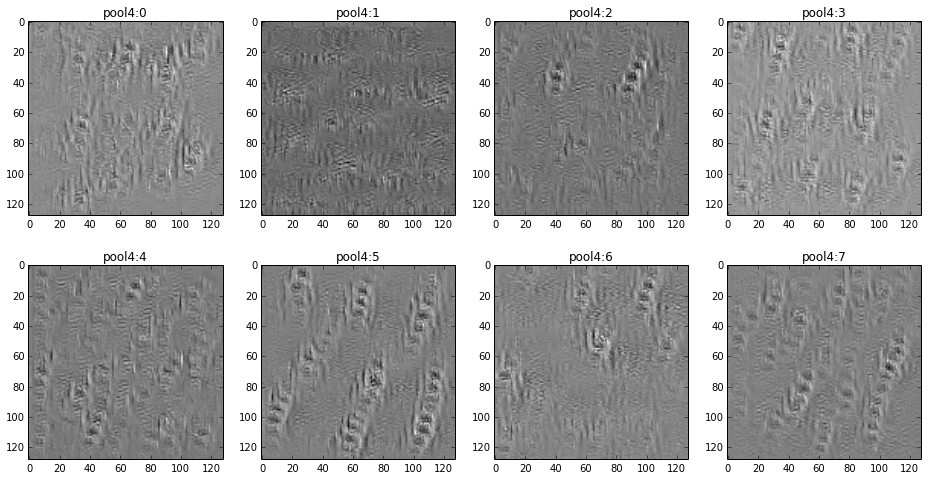

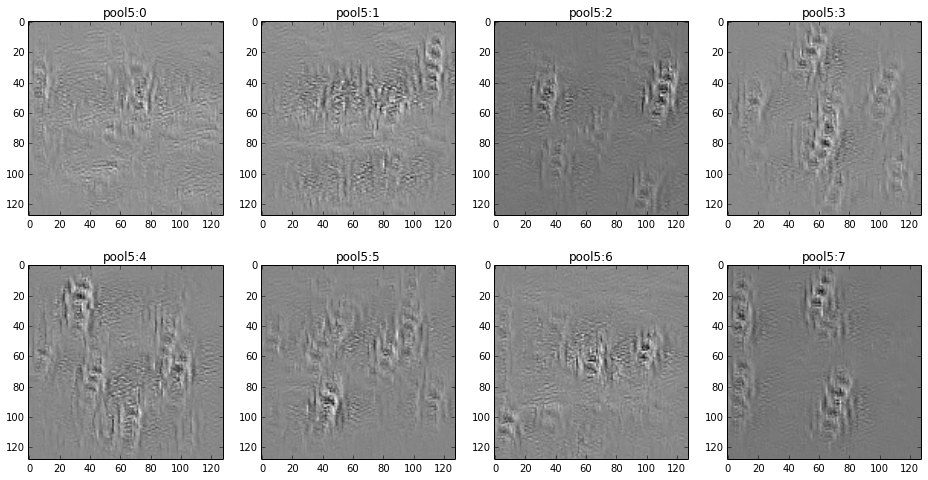

In [43]:
def dream_layer_filter(layer_name, filter_index):

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])
    
    input_img = layer_dict['input_img'].input

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    # run gradient ascent for 20 steps
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step

        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    return img
    #img = deprocess_image(img)
    
    
for layer_name in ['pool2', 'pool3', 'pool4', 'pool5']:
    pl.figure(figsize=(16, 8))
    for i in range(8):
        pl.subplot(2, 4, i + 1)
        pl.title('%s:%d' % (layer_name, i))
        img = dream_layer_filter(layer_name, i)
        pl.imshow(img, cmap=cm.gray)

# Run the model on kaggle'7 test set

In [29]:
if True:
    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
    
    _d = np.load('../data/data_128_test.npz')
    X_submit = _d['X']
    test_fnames = _d['test_fnames']
    Y_pred, Y_pred_proba, Y_pred_binary = predict(X_submit[:,None,:,:])
    
    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(Y_pred.shape[0]):
        imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
        imre = cv2.morphologyEx(imre, cv2.MORPH_CLOSE, kernel)
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)
        
        if i % 10 == 0:
            print '\r%d / %d' % (i, len(test_fnames)),
            sys.stdout.flush()

5500 / 5508


## Stats on predicted masks

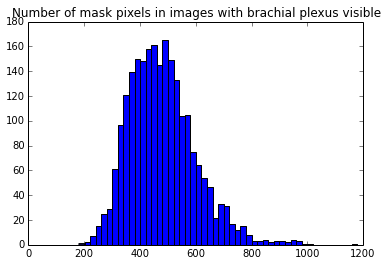

In [67]:
# on Y_full
nbp_pixels = np.sum(np.sum(np.sum(Y_full, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)

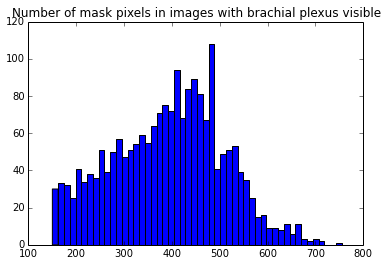

In [68]:
# on pred
nbp_pixels = np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)